**Link DRIVE với COLAB**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/BACH/archive.zip"
extract_path = "/content/BACH_raw"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Giải nén xong trong /content/BACH_raw")
!ls -la /content/BACH_raw | head

Giải nén xong trong /content/BACH_raw
total 12
drwxr-xr-x 3 root root 4096 Dec 15 10:26 .
drwxr-xr-x 1 root root 4096 Dec 15 10:26 ..
drwxr-xr-x 4 root root 4096 Dec 15 10:26 main_folder


**Cài thư viện cần thiết (chỉ chạy 1 lần / notebook mới)**

In [ ]:
!pip install -q scikit-image scikit-learn opencv-python tqdm split-folders albumentations
!pip install -q torch torchvision


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from PIL import Image
from collections import Counter
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import ToPILImage
from torch.utils.tensorboard import SummaryWriter
import gc

In [ ]:
!ls -la /content/drive/MyDrive/BACH_raw

ls: /content/drive/MyDrive/BACH_raw: No such file or directory
lrw------- 1 root root 0 Dec 13 03:59 /content/drive/MyDrive/BACH_raw -> /content/drive/.shortcut-targets-by-id/1zmf_vrVRyiMerlovS9bTzxWLw8ChdCHz/BACH_raw


In [ ]:
class config:
    size = 384
    batchsize = 8 # Adjusted batchsize
    num_epochs = 25
    learning_rate = 5e-5 # Adjusted learning_rate
    num_classes = 4
    use_macenko = True
    patience = 8
    device = "cuda"
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225] #ImageNet
    dropout_rate = 0.3
    weight_decay = 1e-4 # Added weight_decay


### **DATA PREPROCESSING**

In [ ]:
# Remove old intermediate patch directory if it exists
shutil.rmtree("/content/BACH_processed_patches", ignore_errors=True)

# Define paths for training and validation data
TRAIN_VAL_RAW_PATH = "/content/BACH_raw/main_folder/train_folder"

# Define paths for test data
TEST_RAW_PATH = "/content/BACH_raw/main_folder/testing_folder"

output_dir = "/content/drive/MyDrive/my_model_checkpoints"
os.makedirs(output_dir, exist_ok=True)

### K-fold split for cross-validation

In [ ]:
data_dir = TRAIN_VAL_RAW_PATH

image_paths, labels = [], []
class_names = sorted(os.listdir(data_dir))

# Define common image extensions to filter files
IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

for label, cls in enumerate(class_names):
    cls_dir = os.path.join(data_dir, cls)
    for f in os.listdir(cls_dir):
        # Filter out non-image files like .ipynb_checkpoints
        if not f.lower().endswith(IMAGE_EXTENSIONS):
            # print(f"Skipping non-image file/directory: {os.path.join(cls_dir, f)}") # Optionally print what's skipped
            continue
        image_paths.append(os.path.join(cls_dir, f))
        labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = [(train_idx, val_idx) for train_idx, val_idx in kf.split(image_paths, labels)]

### Macenko Stain Normalization

In [ ]:
def rgb2od(I):
    I = np.asarray(I, dtype=np.float32)
    I = np.maximum(I, 1) / 255.0
    OD = -np.log(I)
    return OD

def od2rgb(OD):
    OD = np.clip(OD, 0, 5)
    I = 255 * np.exp(-OD)
    return np.clip(I, 0, 255).astype(np.uint8)

def macenko_normalize(img, alpha=1.0, beta=0.15):
    OD = rgb2od(img).reshape((-1, 3))

    # Remove background
    OD_hat = OD[(OD > beta).any(axis=1)]
    if OD_hat.shape[0] < 10:
        return img

    # PCA
    pca = PCA(n_components=2)
    pca.fit(OD_hat)
    V = pca.components_

    # Project
    C = np.dot(OD, V.T)

    # non-negative concentration
    C = np.maximum(C, 0)

    # Normalize concentration
    max_C = np.percentile(C, 99, axis=0)
    C_normalized = C / (max_C + 1e-8)

    # Reconstruct
    OD_norm = np.dot(C_normalized, V)
    OD_norm = np.maximum(OD_norm, 0)
    OD_norm = OD_norm.reshape(img.shape)

    return od2rgb(OD_norm)


### Transforms

Resize + Normalize dùng std, mean tính trên train dataset

In [ ]:
import torchvision.transforms as T

def get_transforms(mean, std):
    train_tf = T.Compose([
        ToPILImage(),
        T.Resize((config.size, config.size)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

    val_tf = T.Compose([
        ToPILImage(),
        T.Resize((config.size, config.size)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
    return train_tf, val_tf


### Dataset cho train/val datasets

In [ ]:
class BachDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, use_macenko=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.use_macenko = use_macenko

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = np.array(Image.open(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.use_macenko:
            img = macenko_normalize(img)

        if self.transform:
            img = self.transform(img)

        return img, label

### DataLoader cho mỗi fold

In [ ]:
def get_fold_loaders(fold_id, batch_size=config.batchsize):

    train_idx, val_idx = folds[fold_id]
    train_paths = image_paths[train_idx]
    val_paths   = image_paths[val_idx]
    train_labels = labels[train_idx]
    val_labels   = labels[val_idx]

    # Step 2: create transforms
    train_tf, val_tf = get_transforms(config.mean, config.std)

    # Step 3: datasets
    train_ds = BachDataset(train_paths, train_labels,
                                transform=train_tf, use_macenko=config.use_macenko)

    val_ds = BachDataset(val_paths, val_labels,
                              transform=val_tf, use_macenko=config.use_macenko)

    # Step 4: loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=1, pin_memory=True)

    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=1, pin_memory=True)

    return train_loader, val_loader

### Visualize

In [ ]:
def show_samples(dataloader, title, num_samples=5):
    print(f"\n{title} - Total Batches: {len(dataloader)} | Total Samples: {len(dataloader.dataset)}")

    # Obtain a batch of images and labels from the dataloader
    images, labels = next(iter(dataloader))

    num_samples = min(num_samples, images.shape[0])

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        img_tensor = images[i]
        img = TF.to_pil_image(img_tensor.cpu())
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        img_shape = tuple(img_tensor.shape)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nShape: {img_shape}")
        axes[i].axis("off")

    plt.show()

## **Training with EfficientNet B0**

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def create_model(num_classes=config.num_classes, dropout_rate=config.dropout_rate, device=config.device):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Get the number of in_features for the last linear layer
    in_features = model.classifier[1].in_features

    # Replace the classifier with a new Sequential module including Dropout
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),  # Add dropout layer
        nn.Linear(in_features, num_classes)
    )
    model = model.to(device)
    return model

# Removed direct model initialization from here, as create_model will be used in train_fold
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, config.num_classes)
# model = model.to(device)


### train_step (1 epoch)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


### train_step (1 epoch)

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


### Train với từng fold

In [ ]:
def train_fold(fold_id, train_loader, val_loader,
               model_fn=None, # Changed default to None
               num_epochs=20, lr=1e-4, device="cuda", patience=8):

    writer = SummaryWriter(log_dir=f"./logs/fold_{fold_id}")

    model = model_fn() if model_fn else create_model() # Call model_fn to get a new model instance
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.0
    epochs_no_improve = 0 # Counter for epochs without improvement
    os.makedirs("./checkpoints", exist_ok=True)

    start_time = time.time() # Start timing for the fold

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Logging
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Acc/train", train_acc, epoch)
        writer.add_scalar("Acc/val", val_acc, epoch)

        print(f"Fold {fold_id} | Epoch {epoch+1}/{num_epochs} | ")

        # Early Stopping Logic
        if val_acc > best_acc:
            best_acc = val_acc
            epochs_no_improve = 0 # Reset counter
            print(f"New best model saved with Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            torch.save(model.state_dict(), os.path.join(output_dir, f"best_fold_{fold_id}.pth"))
        else:
            epochs_no_improve += 1
            print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            if epochs_no_improve == patience:
                print(f"Early stopping triggered in Fold {fold_id} after {patience} epochs with no improvement.")
                break # Stop training for this fold

    end_time = time.time() # End timing for the fold
    fold_duration = end_time - start_time
    print(f"Fold {fold_id} training completed in {fold_duration:.2f} seconds.")

    writer.close()
    return best_acc

### Chạy K-fold


Train Samples - Total Batches: 40 | Total Samples: 320


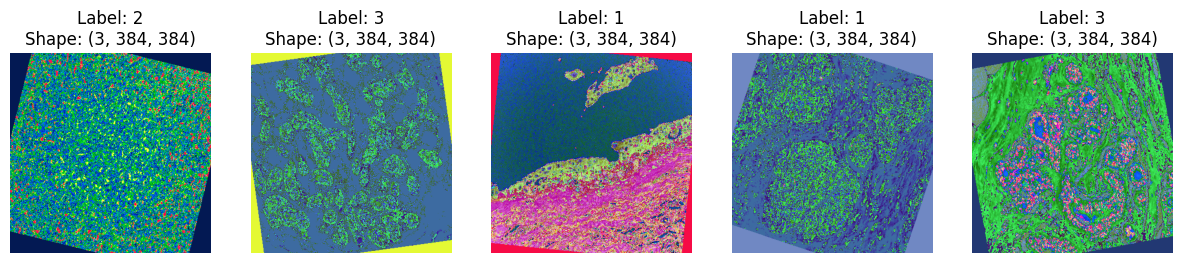


Validation Samples - Total Batches: 10 | Total Samples: 80


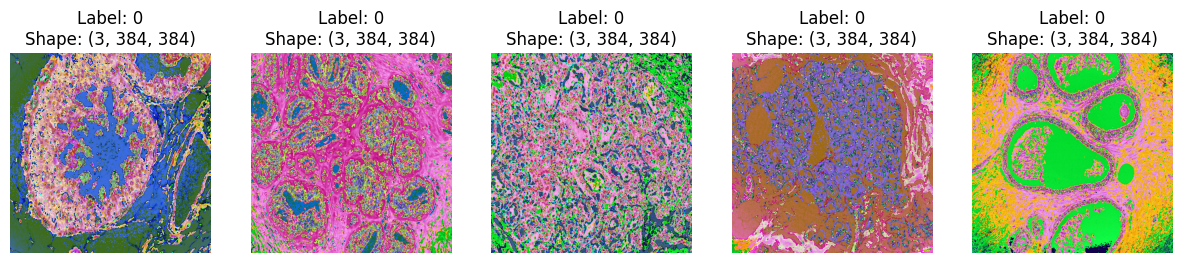

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


Fold 0 | Epoch 1/25 | 
New best model saved with Train Acc: 0.3219 | Val Acc: 0.4750
Fold 0 | Epoch 2/25 | 
New best model saved with Train Acc: 0.5344 | Val Acc: 0.5625
Fold 0 | Epoch 3/25 | 
New best model saved with Train Acc: 0.6125 | Val Acc: 0.6375
Fold 0 | Epoch 4/25 | 
New best model saved with Train Acc: 0.6813 | Val Acc: 0.7250
Fold 0 | Epoch 5/25 | 
Train Acc: 0.7375 | Val Acc: 0.7250
Fold 0 | Epoch 6/25 | 
New best model saved with Train Acc: 0.7656 | Val Acc: 0.8000
Fold 0 | Epoch 7/25 | 
New best model saved with Train Acc: 0.8094 | Val Acc: 0.8250
Fold 0 | Epoch 8/25 | 
New best model saved with Train Acc: 0.7688 | Val Acc: 0.8500
Fold 0 | Epoch 9/25 | 
Train Acc: 0.7781 | Val Acc: 0.8250
Fold 0 | Epoch 10/25 | 
Train Acc: 0.8469 | Val Acc: 0.8500
Fold 0 | Epoch 11/25 | 
Train Acc: 0.8313 | Val Acc: 0.8375
Fold 0 | Epoch 12/25 | 
New best model saved with Train Acc: 0.8750 | Val Acc: 0.8625
Fold 0 | Epoch 13/25 | 
Train Acc: 0.8688 | Val Acc: 0.8500
Fold 0 | Epoch 14/25 

In [ ]:
all_fold_acc = []

for fold_id in range(5):
    train_loader, val_loader = get_fold_loaders(fold_id)

    show_samples(train_loader, "Train Samples")
    # Display more samples for validation to better visualize label distribution
    show_samples(val_loader, "Validation Samples")

    best_acc = train_fold(
        fold_id,
        train_loader,
        val_loader,
        model_fn=create_model,
        num_epochs= config.num_epochs,
        lr= config.learning_rate,
        device= config.device,
        patience=config.patience # Added patience parameter for early stopping
    )

    # Explicitly delete objects to free memory
    del train_loader, val_loader

    # Clear CUDA memory and collect garbage
    torch.cuda.empty_cache()
    gc.collect()

    all_fold_acc.append(best_acc)
    print(f"Fold {fold_id} best accuracy = {best_acc:.4f}")

print("====================================")
print("Final 5-fold accuracy:")
print("Mean =", np.mean(all_fold_acc))
print("Std  =", np.std(all_fold_acc))

### Test model

In [ ]:
test_dir = TEST_RAW_PATH   # set path to Part A

IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

test_img_paths = []
test_labels = []

test_class_names = sorted(os.listdir(test_dir))
for label, cls in enumerate(test_class_names):
    cls_dir = os.path.join(test_dir, cls)
    for f in os.listdir(cls_dir):
        if f.lower().endswith(IMAGE_EXTENSIONS):
            test_img_paths.append(os.path.join(cls_dir, f))
            test_labels.append(label)

test_img_paths = np.array(test_img_paths)
test_labels = np.array(test_labels)

In [ ]:
# Load all 5 fold models
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpts = [os.path.join(output_dir, f"best_fold_{i}.pth") for i in range(5)]
models = []
for ckpt in ckpts:
   m = create_model().to(device)
   m.load_state_dict(torch.load(ckpt, map_location=device))
   m.eval()
   models.append(m)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 122MB/s] 


In [ ]:
infer_tf = T.Compose([
    ToPILImage(), # Moved to the beginning
    T.Resize((config.size, config.size)),
    T.ToTensor(),
    T.Normalize(config.mean, config.std)
])

In [ ]:
def ensemble_k_fold(image_path, models, device, use_macenko, infer_transform):
    img = np.array(Image.open(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if use_macenko:
        img = macenko_normalize(img)

    img_tensor = infer_transform(img)

    all_model_probs = []
    with torch.no_grad():
        for model in models:
            outputs = F.softmax(model(img_tensor.unsqueeze(0).to(device)), dim=1)
            all_model_probs.append(outputs.cpu().numpy())

    avg_model_probs = np.mean(all_model_probs, axis=0)
    final_probs = avg_model_probs[0]

    return final_probs

print("Function ensemble_k_fold defined.")

Function ensemble_k_fold defined.


100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Ensemble Patch-Voting Accuracy: 0.975


<Figure size 640x480 with 0 Axes>

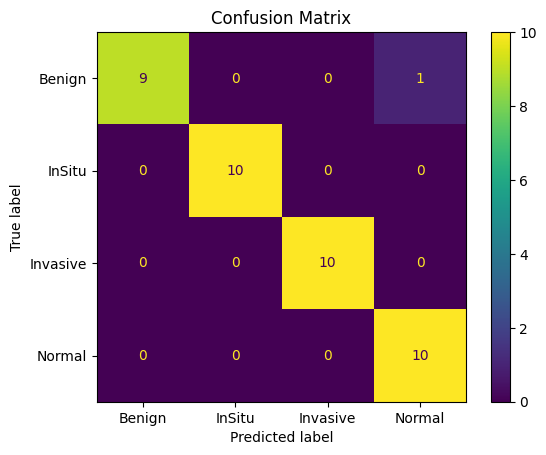

              precision    recall  f1-score   support

      Benign       1.00      0.90      0.95        10
      InSitu       1.00      1.00      1.00        10
    Invasive       1.00      1.00      1.00        10
      Normal       0.91      1.00      0.95        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Evaluate dataset
image_paths_list, labels_list = test_img_paths, test_labels # test dataset

y_true, y_pred = [], []

# Ensure device is defined (it's defined in vGIfhg1-9XKK)
device = "cuda" if torch.cuda.is_available() else "cpu"

for img_path, gt in tqdm(zip(image_paths_list, labels_list), total=len(labels_list)):
    pred_probs = ensemble_k_fold(
        image_path=img_path,
        models=models,
        device=device,
        use_macenko=config.use_macenko,
        infer_transform=infer_tf
    )
    pred = np.argmax(pred_probs)
    y_true.append(gt)
    y_pred.append(pred)

print("Ensemble Patch-Voting Accuracy:", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure()
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))